# **Dhwani Bhavankar**
## **AIML A2**
### **22070126034**

#### **1. Understanding Large Language Models (LLMs)**

**Large Language Models (LLMs)** are deep learning models trained on massive amounts of text data to understand and generate human-like language. These models are built using transformer architectures, which are designed to capture contextual relationships between words or tokens. LLMs, such as GPT, BERT, and T5, are generally pre-trained on a wide variety of tasks (like next-word prediction or masked token prediction), enabling them to generate coherent, contextually appropriate text.

LLMs are typically pre-trained in two main ways:

1. **Generative Pre-training**: The model is trained to predict the next word in a sequence, enabling it to generate text and understand context. Examples include GPT and GPT-2/3.
  
2. **Masked Language Modeling**: In this approach, the model is trained to predict missing or "masked" words in a sentence. This training approach is used by models like BERT and T5, focusing on bidirectional understanding of context.

Pre-training gives LLMs a general language understanding, but for specific tasks like Question Answering, Sentiment Analysis, or Named Entity Recognition, these models need further fine-tuning.

#### **2. Fine-Tuning: Customizing Pre-trained Models for Specific Tasks**

**Fine-tuning** is the process of adapting a pre-trained model to perform a specific downstream task using labeled data for that task. This process allows the model to learn the nuances and patterns required for the specific application, improving its performance significantly in that domain.

**Steps Involved in Fine-Tuning:**

1. **Data Preparation**: A labeled dataset relevant to the specific task (e.g., question-answer pairs for Question Answering) is prepared. The input format varies depending on the task:
   - **For QA**: The model receives a passage and question as input and learns to output the correct answer.
   - **For Chatbot Fine-Tuning**: Dialogues are structured in pairs of input-output sentences, allowing the model to learn conversational patterns.

2. **Model Initialization**: The pre-trained weights of the LLM are loaded, providing the model with a foundation of general language understanding.

3. **Training Objective**: The model is trained to minimize a task-specific loss function:
   - **Cross-Entropy Loss** for classification tasks or token prediction tasks.
   - **Sequence Loss** for tasks requiring text generation, like answering questions or generating responses in chat.

4. **Optimization and Backpropagation**: The model's parameters are updated iteratively to improve its predictions. During fine-tuning, the learning rate is generally lower to prevent overwriting the valuable pre-trained weights.

5. **Evaluation and Validation**: The model is evaluated on a validation set to check its performance and adjust hyperparameters if necessary.

#### **3. Chatbots and How They Work**

A **Chatbot** is an application designed to simulate human conversation, allowing users to interact with a machine in natural language. Modern chatbots use LLMs and fine-tuning techniques to produce human-like responses. They work by processing user input, understanding the intent, and generating an appropriate response based on learned patterns from pre-trained data.

**Types of Chatbots**:

1. **Rule-Based Chatbots**: Operate based on a set of predefined rules or scripts. They are limited to specific scenarios and cannot handle complex interactions or nuanced responses.
  
2. **AI-Driven Chatbots**: Use machine learning and NLP, particularly LLMs, to understand context and generate responses dynamically. These chatbots can handle a wider range of inputs and adapt to varied user inquiries.

**How LLM-Powered Chatbots Work**:

1. **Input Processing**: The chatbot receives user input and tokenizes it (breaks it down into words or subwords). This input is then passed through the model.

2. **Intent Detection**: LLMs understand the context and intent of the input using pre-trained and fine-tuned weights. The model decodes the intent based on the input and its learned knowledge.

3. **Response Generation**: The model generates a response by predicting the most likely sequence of tokens that would follow, creating a coherent reply. This process is either:
   - **Extractive**: Extracting relevant information directly from a passage (useful in customer support chatbots).
   - **Generative**: Producing entirely new responses based on learned language patterns.

4. **Output**: The response is returned to the user, and the conversation can continue in a loop.

**Example**: Fine-tuning a GPT-based model for chatbot tasks involves training it on conversational data, allowing it to learn how to respond accurately and naturally to various types of user inquiries.

#### **4. Importance of Fine-Tuning in QA and Chatbot Applications**

Fine-tuning enables LLMs to specialize in specific tasks, significantly enhancing their performance. In Question Answering, fine-tuning allows the model to focus on accurately retrieving or generating answers to questions based on context. For chatbots, fine-tuning refines the model’s conversational abilities, making it more capable of handling real-world scenarios and producing responses that are contextually accurate and coherent.

Fine-tuning thus tailors large language models to domain-specific needs, improving their performance, accuracy, and usability in applications like QA and conversational AI.


# **Part A: Using BERT to understand finetuing of LLM and also understand thre working of chatbot before finetuning bigger models like GPT, T5 and DistillBERT**

In [17]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import nltk

# Download NLTK data for BLEU score calculation
nltk.download('punkt')

#Ignore Warnings
import logging
logging.disable(logging.WARNING)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##Load Dataset and Process Dataset

In [18]:
# Load CoQA dataset
def load_coqa_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']

# Custom dataset class
class CoQADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        context = item['story']
        question = item['questions'][0]['input_text']
        answer = item['answers'][0]['input_text']

        # Tokenize the input
        inputs = self.tokenizer.encode_plus(
            question,
            context,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Find the start and end positions of the answer in the tokenized input
        input_ids = inputs['input_ids'][0]
        answer_tokens = self.tokenizer.encode(answer, add_special_tokens=False)
        start_position = None
        end_position = None

        for i in range(len(input_ids) - len(answer_tokens) + 1):
            if input_ids[i:i+len(answer_tokens)].tolist() == answer_tokens:
                start_position = i
                end_position = i + len(answer_tokens) - 1
                break

        # If the answer is not found, use the CLS token position as a default
        if start_position is None:
            start_position = 0
            end_position = 0

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'start_positions': torch.tensor(start_position),
            'end_positions': torch.tensor(end_position),
            'answer': answer
        }

### Train, Validation and Test Split

In [20]:
data = load_coqa_data('/content/coqa-train-v1.0.json')
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

###Tokenization and DataLoader

In [4]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare datasets and dataloaders
train_dataset = CoQADataset(train_data, tokenizer)
val_dataset = CoQADataset(val_data, tokenizer)
test_dataset = CoQADataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


##Training Function

In [5]:
# Training function
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(train_loader)

###Model Initialization

In [6]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')



# Set device and move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


##Validation

In [7]:
# Validation function
def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    progress_bar = tqdm(val_loader, desc="Validating")
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs.loss
            total_loss += loss.item()

            progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(val_loader)

##Test

In [8]:
# Test function
def test(model, test_loader, tokenizer, device):
    model.eval()
    all_predictions = []
    all_answers = []
    progress_bar = tqdm(test_loader, desc="Testing")
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            answers = batch['answer']

            outputs = model(input_ids, attention_mask=attention_mask)
            start_scores = outputs.start_logits
            end_scores = outputs.end_logits

            for i in range(input_ids.shape[0]):
                start_index = torch.argmax(start_scores[i])
                end_index = torch.argmax(end_scores[i])
                prediction = tokenizer.decode(input_ids[i][start_index:end_index+1])
                all_predictions.append(prediction)
                all_answers.append(answers[i])

    bleu_score = calculate_bleu(all_predictions, all_answers)
    return bleu_score

In [9]:
# Training loop
num_epochs = 3
best_loss = float('inf')
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'bert_qa_model.pth')
        print("Model saved!")
    else:
        print("Validation Loss Increased. Model Not Saved.")
    print("*" * 50)

Epoch 1/3


Validating: 100%|██████████| 135/135 [00:38<00:00,  3.52it/s, loss=1.74]


Train Loss: 2.6912, Validation Loss: 2.0209
Model saved!
**************************************************
Epoch 2/3


Validating: 100%|██████████| 135/135 [00:38<00:00,  3.48it/s, loss=1.76]


Train Loss: 1.3274, Validation Loss: 2.0052
Model saved!
**************************************************
Epoch 3/3


Validating: 100%|██████████| 135/135 [00:38<00:00,  3.53it/s, loss=3.15]

Train Loss: 0.6464, Validation Loss: 2.5565
Validation Loss Increased. Model Not Saved.
**************************************************


##BLEU Score

In [10]:
# Calculate BLEU score
def calculate_bleu(predictions, references):
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        bleu_scores.append(sentence_bleu([ref.split()], pred.split()))
    return sum(bleu_scores) / len(bleu_scores)


In [11]:
# Test the model
bleu_score = test(model, test_loader, tokenizer, device)
print(f"BLEU Score: {bleu_score:.4f}")


Testing: 100%|██████████| 135/135 [00:39<00:00,  3.45it/s]

BLEU Score: 0.0094



/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(

In [ ]:
# Create a simple QA bot
def qa_bot(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        start_scores = outputs.start_logits
        end_scores = outputs.end_logits

    start_index = torch.argmax(start_scores)
    end_index = torch.argmax(end_scores)
    answer = tokenizer.decode(input_ids[0][start_index:end_index+1])
    return answer

In [15]:
# Example usage of the QA bot
context = test_data[0]['story']
question = "When did French started using the right side?"
answer = qa_bot(context, question)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: When did French started using the right side?
Answer: since at least the late 18th century


In [16]:
print("*" * 50)

**************************************************


# **Part B : Model Finetuning and deployment**

## **Part 1: T5 Model :**

In [1]:
# Import necessary libraries
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import nltk

# Download NLTK data for BLEU score calculation
nltk.download('punkt')

# Ignore Warnings
import logging
logging.disable(logging.WARNING)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
def load_coqa_data(file_path):
    # Load CoQA dataset from a JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)  # Read JSON data
    return data['data']  # Return the 'data' field from the JSON

# Custom dataset class for CoQA
class CoQADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        # Initialize dataset with data, tokenizer, and max sequence length
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the item at index idx
        item = self.data[idx]
        context = item['story']  # Extract the story context
        question = item['questions'][0]['input_text']  # Extract the question
        answer = item['answers'][0]['input_text']  # Extract the answer

        # Format input for T5: "question: <question> context: <context>"
        input_text = f"question: {question} context: {context}"
        target_text = answer  # The target output is the answer

        # Tokenize the input and target texts
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'  # Return as PyTorch tensors
        )

        labels = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'  # Return as PyTorch tensors
        )

        # Return a dictionary with input IDs, attention mask, and labels
        return {
            'input_ids': inputs['input_ids'].flatten(),  # Flatten to 1D
            'attention_mask': inputs['attention_mask'].flatten(),  # Flatten to 1D
            'labels': labels['input_ids'].flatten()  # Flatten to 1D for T5 labels
        }

In [3]:
# Load and split the data
data = load_coqa_data("/content/coqa-train-v1.0.json")
# Split the data into training (70%), validation (15%), and test (15%) sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)


In [4]:
# Initialize tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')  # Load T5 tokenizer

# Create datasets for training, validation, and testing
train_dataset = CoQADataset(train_data, tokenizer)
val_dataset = CoQADataset(val_data, tokenizer)
test_dataset = CoQADataset(test_data, tokenizer)

# Create data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [5]:
def train(model, train_loader, optimizer, device):
    # Function to train the model for one epoch
    model.train()  # Set model to training mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(train_loader, desc="Training")  # Create a progress bar

    for batch in progress_bar:
        optimizer.zero_grad()  # Zero the gradients

        # Move batch data to the specified device (CPU or GPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass with T5
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Get the loss from the output
        loss = outputs.loss
        total_loss += loss.item()  # Accumulate loss

        # Backward pass and optimization step
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Update progress bar with current loss
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(train_loader)  # Return average loss


In [6]:
# Initialize model and optimizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')  # Load T5 model

# Set device and move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set optimizer with learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
def validate(model, val_loader, device):
    # Function to validate the model on the validation set
    model.eval()  # Set model to evaluation mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(val_loader, desc="Validating")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with T5
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # Get loss
            total_loss += loss.item()  # Accumulate loss

            progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(val_loader)  # Return average loss


In [8]:
# Test function to evaluate the model on the test set
def test(model, test_loader, tokenizer, device):
    model.eval()  # Set model to evaluation mode
    all_predictions = []  # List to store predictions
    all_answers = []  # List to store true answers
    progress_bar = tqdm(test_loader, desc="Testing")  # to Create a progress bar showing the time takien and left

    with torch.no_grad():  # Disable gradient computation
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Generate answer using T5
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=50, num_beams=5, early_stopping=True)
            prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)  # Decode the prediction

            # Collect the predictions
            all_predictions.append(prediction)

            # Decode the true answer for BLEU score calculation
            true_answer = tokenizer.decode(batch['labels'][0], skip_special_tokens=True)
            all_answers.append(true_answer)

    # Calculate BLEU score based on predictions and true answers
    bleu_score = calculate_bleu(all_predictions, all_answers)
    return bleu_score


In [9]:
# Calculate BLEU score
def calculate_bleu(predictions, references):
    # Function to calculate the average BLEU score for the predictions
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        # Compute BLEU score for each prediction-reference pair
        bleu_scores.append(sentence_bleu([ref.split()], pred.split()))  # Split strings into words
    return sum(bleu_scores) / len(bleu_scores)  # Return average BLEU score


In [10]:
# Set number of training epochs
num_epochs = 3
best_loss = float('inf')  # Initialize best loss for model saving

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, device)  # Train for one epoch
    val_loss = validate(model, val_loader, device)  # Validate after training
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Save the model if validation loss has improved
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 't5_qa_model.pth')  # Save the model state
        print("Model saved!")
    else:
        print("Validation Loss Increased. Model Not Saved.")
    print("*" * 50)

Epoch 1/3


Validating: 100%|██████████| 135/135 [00:32<00:00,  4.15it/s, loss=0.0591]


Train Loss: 0.7226, Validation Loss: 0.0614
Model saved!
**************************************************
Epoch 2/3


Validating: 100%|██████████| 135/135 [00:32<00:00,  4.15it/s, loss=0.0221]


Train Loss: 0.0497, Validation Loss: 0.0257
Model saved!
**************************************************
Epoch 3/3


Validating: 100%|██████████| 135/135 [00:32<00:00,  4.16it/s, loss=0.0119]


Train Loss: 0.0230, Validation Loss: 0.0129
Model saved!
**************************************************


In [11]:
# Test the model and compute BLEU score
bleu_score = test(model, test_loader, tokenizer, device)
print(f"BLEU Score: {bleu_score:.4f}")

Testing: 100%|██████████| 135/135 [00:48<00:00,  2.79it/s]

BLEU Score: 0.0614



/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(

## **Part 2: Distilbert Model:**

In [12]:
# Import necessary libraries
import json  # For loading JSON data
import torch  # Main library for tensor operations and deep learning
from torch.utils.data import Dataset, DataLoader  # For creating datasets and loading data in batches
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering, AdamW  # For the DistilBERT model and tokenizer
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and test sets
from tqdm import tqdm  # For progress bars during training and evaluation
from nltk.translate.bleu_score import sentence_bleu  # For calculating the BLEU score
import nltk  # Natural Language Toolkit


In [13]:
def load_coqa_data(file_path):
    """Load CoQA dataset from a JSON file."""
    with open(file_path, 'r') as f:
        data = json.load(f)  # Read JSON data into a Python dictionary
    return data['data']  # Return the 'data' key from the JSON

class CoQADataset(Dataset):
    """Custom dataset class for CoQA."""

    def __init__(self, data, tokenizer, max_length=512):
        """
        Initialize the dataset.

        Args:
            data: List of CoQA data entries.
            tokenizer: Tokenizer for the model.
            max_length: Maximum length for tokenization.
        """
        self.data = data  # Store the data
        self.tokenizer = tokenizer  # Store the tokenizer
        self.max_length = max_length  # Set maximum length for input sequences

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset."""
        item = self.data[idx]  # Get the data entry at index idx
        context = item['story']  # Extract the story context
        question = item['questions'][0]['input_text']  # Extract the first question
        answer = item['answers'][0]['input_text']  # Extract the first answer

        # Tokenize the input question and context
        inputs = self.tokenizer.encode_plus(
            question,
            context,
            add_special_tokens=True,  # Add [CLS] and [SEP] tokens
            max_length=self.max_length,
            padding='max_length',  # Pad sequences to max_length
            truncation=True,  # Truncate sequences longer than max_length
            return_tensors='pt'  # Return as PyTorch tensors
        )

        # Find the start and end positions of the answer in the tokenized input
        input_ids = inputs['input_ids'][0]  # Get the input IDs for the first entry
        answer_tokens = self.tokenizer.encode(answer, add_special_tokens=False)  # Encode the answer without special tokens
        start_position = None
        end_position = None

        # Search for the answer tokens in the input IDs
        for i in range(len(input_ids) - len(answer_tokens) + 1):
            if input_ids[i:i+len(answer_tokens)].tolist() == answer_tokens:  # Check for a match
                start_position = i  # Set start position
                end_position = i + len(answer_tokens) - 1  # Set end position
                break

        # If the answer is not found, use the CLS token position as a default
        if start_position is None:
            start_position = 0  # Default to the start of the input
            end_position = 0  # Default end position

        # Return a dictionary with the necessary information
        return {
            'input_ids': inputs['input_ids'].flatten(),  # Flatten input IDs to 1D
            'attention_mask': inputs['attention_mask'].flatten(),  # Flatten attention mask to 1D
            'start_positions': torch.tensor(start_position),  # Convert start position to tensor
            'end_positions': torch.tensor(end_position),  # Convert end position to tensor
            'answer': answer  # Store the answer
        }

In [14]:
# Load CoQA data from the specified JSON file
data = load_coqa_data("/content/coqa-train-v1.0.json")

# Split the data into training (70%) and test (30%) sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
# Further split the test data into validation (15%) and test (15%) sets
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)


In [15]:
# Initialize the tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets for training, validation, and testing
train_dataset = CoQADataset(train_data, tokenizer)
val_dataset = CoQADataset(val_data, tokenizer)
test_dataset = CoQADataset(test_data, tokenizer)

# Create DataLoader instances for batching the datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=8)  # No shuffling for validation
test_loader = DataLoader(test_dataset, batch_size=8)  # No shuffling for testing

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
def train(model, train_loader, optimizer, device):
    """Train the model for one epoch."""
    model.train()  # Set model to training mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(train_loader, desc="Training")  # Create a progress bar

    for batch in progress_bar:
        optimizer.zero_grad()  # Zero the gradients for the optimizer

        # Move batch data to the specified device (CPU or GPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        # Forward pass with DistilBERT
        outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                        start_positions=start_positions, end_positions=end_positions)

        # Get the loss from the output
        loss = outputs.loss

        # Average loss across GPUs (if using multiple)
        loss = loss.mean()  # In case of distributed training, take the mean loss

        total_loss += loss.item()  # Accumulate loss

        # Backward pass and optimization step
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Update progress bar with current loss
        progress_bar.set_postfix({'loss': loss.item()})

    # Return the average loss over all batches
    return total_loss / len(train_loader)

In [17]:
# Initialize model and optimizer
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')  # Load the pre-trained DistilBERT model

# Set device for training (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move model to the device

# Set optimizer with a learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)  # AdamW optimizer for weight decay

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
def validate(model, val_loader, device):
    """Validate the model on the validation set."""
    model.eval()  # Set model to evaluation mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(val_loader, desc="Validating")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            # Forward pass with DistilBERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                            start_positions=start_positions, end_positions=end_positions)
            loss = outputs.loss  # Get the loss
            total_loss += loss.item()  # Accumulate loss

            progress_bar.set_postfix({'loss': loss.item()})

    # Return average loss over validation batches
    return total_loss / len(val_loader)

In [19]:
# Test function to evaluate the model on the test set
def test(model, test_loader, tokenizer, device):
    """Test the model and calculate BLEU score."""
    model.eval()  # Set model to evaluation mode
    all_predictions = []  # List to store predictions
    all_answers = []  # List to store true answers
    progress_bar = tqdm(test_loader, desc="Testing")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation during testing
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Get the predicted start and end positions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            start_logits = outputs.start_logits  # Start position logits
            end_logits = outputs.end_logits  # End position logits

            # Get predicted start and end positions
            start_positions = torch.argmax(start_logits, dim=1)  # Get index of max start logit
            end_positions = torch.argmax(end_logits, dim=1)  # Get index of max end logit

            # Decode the predicted answer from the context
            for i in range(input_ids.size(0)):
                # Slice the input IDs based on predicted start and end positions
                input_id_slice = input_ids[i][start_positions[i]:end_positions[i] + 1]
                prediction = tokenizer.decode(input_id_slice, skip_special_tokens=True)  # Decode to text
                all_predictions.append(prediction)  # Store prediction

                # Decode the true answer for BLEU score calculation
                true_answer = tokenizer.decode(batch['input_ids'][i][batch['start_positions'][i]:batch['end_positions'][i]+1], skip_special_tokens=True)
                all_answers.append(true_answer)  # Store true answer

    # Calculate BLEU score based on predictions and true answers
    bleu_score = calculate_bleu(all_predictions, all_answers)
    return bleu_score

In [20]:
num_epochs = 3
best_loss = float('inf')  # Initialize the best validation loss as infinity

# Loop through each epoch for training
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, device)  # Train the model
    val_loss = validate(model, val_loader, device)  # Validate the model
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")  # Print losses

    # Save the model if validation loss improves
    if val_loss < best_loss:
        best_loss = val_loss  # Update the best loss
        torch.save(model.state_dict(), 'distilbert_qa_model.pth')  # Save model state
        print("Model saved!")
    else:
        print("Validation Loss Increased. Model Not Saved.")
    print("*" * 50)

Epoch 1/3


Validating: 100%|██████████| 135/135 [00:24<00:00,  5.48it/s, loss=2.57]


Train Loss: 2.8543, Validation Loss: 2.1133
Model saved!
**************************************************
Epoch 2/3


Validating: 100%|██████████| 135/135 [00:24<00:00,  5.48it/s, loss=2.47]


Train Loss: 1.4925, Validation Loss: 2.1485
Validation Loss Increased. Model Not Saved.
**************************************************
Epoch 3/3


Validating: 100%|██████████| 135/135 [00:24<00:00,  5.49it/s, loss=3.2]

Train Loss: 0.7427, Validation Loss: 2.6909
Validation Loss Increased. Model Not Saved.
**************************************************


In [21]:
# Calculate BLEU score
def calculate_bleu(predictions, references):
    """Calculate the average BLEU score for a set of predictions against references."""
    bleu_scores = []  # List to store BLEU scores
    for pred, ref in zip(predictions, references):
        # Calculate BLEU score for each prediction against the reference
        bleu_scores.append(sentence_bleu([ref.split()], pred.split()))  # Use sentence_bleu from nltk
    return sum(bleu_scores) / len(bleu_scores)  # Return average BLEU score

In [22]:
# Test the model and calculate BLEU score
bleu_score = test(model, test_loader, tokenizer, device)
print(f"BLEU Score: {bleu_score:.4f}")  # Print the BLEU score

Testing: 100%|██████████| 135/135 [00:24<00:00,  5.50it/s]


BLEU Score: 0.0384


## **Part 3: GPT-2 Model:**

In [23]:
# Import necessary libraries
import json  # For loading and working with JSON data
import torch  # Main library for tensor operations and deep learning
from torch.utils.data import Dataset, DataLoader  # For creating custom datasets and loading data in batches
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW  # For GPT-2 model and tokenizer
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and test sets
from tqdm import tqdm  # For progress bars during training and evaluation
from nltk.translate.bleu_score import sentence_bleu  # For calculating BLEU score for evaluating generated text
import nltk  # Natural Language Toolkit

# Download NLTK punkt tokenizer model for sentence tokenization
nltk.download('punkt')

# Disable warning messages from logging
import logging
logging.disable(logging.WARNING)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
# Function to load the CoQA dataset from a JSON file
def load_coqa_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)  # Load the JSON data into a Python dictionary
    return data['data']  # Return only the 'data' section of the JSON

# Custom dataset class for CoQA
class CoQADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        """
        Initialize the dataset.

        Args:
            data: List of CoQA data entries.
            tokenizer: Tokenizer for the model (GPT-2).
            max_length: Maximum length for tokenization.
        """
        self.data = data  # Store the dataset entries
        self.tokenizer = tokenizer  # Store the tokenizer
        self.max_length = max_length  # Set the maximum sequence length

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset by index."""
        item = self.data[idx]  # Get the data entry at index idx
        context = item['story']  # Extract the story context
        question = item['questions'][0]['input_text']  # Extract the first question
        answer = item['answers'][0]['input_text']  # Extract the first answer

        # Format the input text for the model
        input_text = f"Context: {context} Question: {question} Answer briefly:"
        target_text = answer  # Set the target text (answer)

        # Tokenize the input text and target text
        inputs = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,  # Add special tokens (like <|endoftext|>)
            max_length=self.max_length,
            padding='max_length',  # Pad sequences to max_length
            truncation=True,  # Truncate sequences longer than max_length
            return_tensors='pt'  # Return as PyTorch tensors
        )

        targets = self.tokenizer.encode_plus(
            target_text,
            add_special_tokens=True,  # Add special tokens
            max_length=self.max_length,
            padding='max_length',  # Pad sequences to max_length
            truncation=True,  # Truncate sequences longer than max_length
            return_tensors='pt'  # Return as PyTorch tensors
        )

        # Return a dictionary containing the input IDs, attention masks, and labels
        return {
            'input_ids': inputs['input_ids'].flatten(),  # Flatten the input IDs to 1D
            'attention_mask': inputs['attention_mask'].flatten(),  # Flatten the attention mask to 1D
            'labels': targets['input_ids'].flatten(),  # Flatten the target IDs to 1D
        }


In [25]:
# Load CoQA data from the specified JSON file
data = load_coqa_data("/content/coqa-train-v1.0.json")

# Split the data into training (70%) and test (30%) sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Further split the test data into validation (15%) and test (15%) sets
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)


In [26]:
# Initialize the GPT-2 tokenizer and set padding token to end-of-sequence token
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 does not have a dedicated padding token, using EOS instead

# Create dataset instances for training, validation, and testing
train_dataset = CoQADataset(train_data, tokenizer)
val_dataset = CoQADataset(val_data, tokenizer)
test_dataset = CoQADataset(test_data, tokenizer)

# Create DataLoader instances for batching the datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Shuffle training data for randomness
val_loader = DataLoader(val_dataset, batch_size=8)  # No shuffling for validation
test_loader = DataLoader(test_dataset, batch_size=8)  # No shuffling for testing

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [27]:
# Initialize the GPT-2 model for language generation
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))  # Resize token embeddings to accommodate padding token

# Set device for training (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the specified device

# Set optimizer with a learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)  # AdamW optimizer for weight decay

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [28]:
# Function to train the model for one epoch
def train(model, train_loader, optimizer, device):
    model.train()  # Set the model to training mode
    total_loss = 0  # Initialize total loss for this epoch
    progress_bar = tqdm(train_loader, desc="Training")  # Create a progress bar

    for batch in progress_bar:
        optimizer.zero_grad()  # Zero the gradients for the optimizer

        # Move batch data to the specified device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # Get the loss from the output
        total_loss += loss.item()  # Accumulate the loss

        # Backward pass and optimization step
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Update progress bar with current loss
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(train_loader)  # Return average loss over the training data


In [29]:
# Function to validate the model on the validation set
def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(val_loader, desc="Validating")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation during validation
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass through the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # Get the loss
            total_loss += loss.item()  # Accumulate loss

            # Update progress bar with current loss
            progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(val_loader)  # Return average loss over validation data

In [30]:
# Function to calculate BLEU score for evaluating generated text
def calculate_bleu(predictions, references):
    # Calculate BLEU scores for each prediction against its reference
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for pred, ref in zip(predictions, references)]
    return sum(bleu_scores) / len(bleu_scores)  # Return average BLEU score


In [31]:
# Function to test the model and evaluate its performance
def test(model, test_loader, tokenizer, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []  # List to store all generated predictions
    all_answers = []  # List to store all true answers
    progress_bar = tqdm(test_loader, desc="Testing")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation during testing
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Generate concise answer using the model
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=30,  # Limit the length of the generated answer
                num_beams=3,  # Use beam search for generating multiple sequences
                temperature=0.5,  # Control randomness of predictions
                early_stopping=True  # Stop generating once the end token is reached
            )
            prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)  # Decode the generated output

            all_predictions.append(prediction)  # Store generated prediction

            # Decode the true answer for BLEU score calculation
            true_answer = tokenizer.decode(batch['labels'][0], skip_special_tokens=True)
            all_answers.append(true_answer)  # Store true answer

    bleu_score = calculate_bleu(all_predictions, all_answers)  # Calculate BLEU score
    return bleu_score  # Return the BLEU score

In [32]:
# Main training loop
num_epochs = 3  # Set the number of epochs for training
best_loss = float('inf')  # Initialize the best validation loss as infinity

# Loop through each epoch for training and validation
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, device)  # Train the model
    val_loss = validate(model, val_loader, device)  # Validate the model
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")  # Print losses

    # Save the model if validation loss improves
    if val_loss < best_loss:
        best_loss = val_loss  # Update the best loss
        torch.save(model.state_dict(), 'gpt2_qa_model.pth')  # Save model state
        print("Model saved!")  # Confirmation of model saving
    else:
        print("Validation Loss Increased. Model Not Saved.")  # Indicate no improvement
    print("*" * 50)

Epoch 1/3


Validating: 100%|██████████| 135/135 [00:50<00:00,  2.70it/s, loss=0.0739]


Train Loss: 0.0991, Validation Loss: 0.0503
Model saved!
**************************************************
Epoch 2/3


Validating: 100%|██████████| 135/135 [00:49<00:00,  2.71it/s, loss=0.0726]


Train Loss: 0.0504, Validation Loss: 0.0500
Model saved!
**************************************************
Epoch 3/3


Validating: 100%|██████████| 135/135 [00:49<00:00,  2.72it/s, loss=0.0717]

Train Loss: 0.0489, Validation Loss: 0.0504
Validation Loss Increased. Model Not Saved.
**************************************************


In [33]:
# Test the model and calculate BLEU score
bleu_score = test(model, test_loader, tokenizer, device)
print(f"BLEU Score: {bleu_score:.4f}")  # Print the calculated BLEU score

Testing:   0%|          | 0/135 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Testing: 100%|██████████| 135/135 [02:22<00:00,  1.06s/it]

BLEU Score: 0.0031


## **Part 4:Gradio for UI:**

In [35]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2

In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DistilBertForQuestionAnswering, DistilBertTokenizer, T5ForConditionalGeneration, T5Tokenizer
import gradio as gr

In [2]:
def load_models():

    # Load T5
    t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
    t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
    t5_model.load_state_dict(torch.load('t5_qa_model.pth'))
    t5_model.eval()

    # Load T5
    t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
    t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
    t5_model.load_state_dict(torch.load('t5_qa_model.pth'))
    t5_model.eval()

    # Load GPT-2
    gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    gpt2_model.load_state_dict(torch.load('gpt2_qa_model.pth'))
    gpt2_model.eval()

    # Load DistilBERT
    distilbert_model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
    distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    distilbert_model.load_state_dict(torch.load('distilbert_qa_model.pth'))
    distilbert_model.eval()



    return (gpt2_model, gpt2_tokenizer), (distilbert_model, distilbert_tokenizer), (t5_model, t5_tokenizer)

gpt2, distilbert, t5 = load_models()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
<ipython-input-2-e47

In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set padding token to EOS token

gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_model.resize_token_embeddings(len(tokenizer))


Embedding(50257, 768)

In [4]:
import torch

# Assuming you have the following model loading code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2 = (gpt2_model, tokenizer)  # Replace this with your model and tokenizer loading code
gpt2[0].to(device)  # Move the model to the correct device

def gpt2_inference(article, question):
    # Create a structured input to guide the model
    input_text = f"Context: {article}\nQuestion: {question}\nProvide a clear and concise answer:"

    # Tokenize input and move to the appropriate device
    inputs = gpt2[1].encode(input_text, return_tensors='pt').to(device)

    # Generate output with settings to avoid overly verbose or repetitive answers
    outputs = gpt2[0].generate(
        inputs,
        max_new_tokens=50,  # Limit the number of tokens to encourage brevity
        do_sample=True,
        temperature=0.7,
        pad_token_id=gpt2[1].eos_token_id,
        num_return_sequences=1,
        top_k=50,  # Limit the sampling to the top-k tokens
        top_p=0.95  # Use nucleus sampling
    )

    # Decode the generated answer
    generated_answer = gpt2[1].decode(outputs[0], skip_special_tokens=True)

    # Extract the answer
    answer_start = generated_answer.find("Provide a clear and concise answer:") + len("Provide a clear and concise answer:")
    answer = generated_answer[answer_start:].strip()

    # Check for validity of the answer
    if len(answer) < 10 or "?" in answer:
        return "Answer not available or too brief."

    return answer


In [5]:
def distilbert_inference(article, question):
    inputs = distilbert[1].encode_plus(question, article, add_special_tokens=True, return_tensors='pt')
    with torch.no_grad():
        outputs = distilbert[0](**inputs)
    answer_start_scores, answer_end_scores = outputs.start_logits, outputs.end_logits
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1
    answer = distilbert[1].convert_tokens_to_string(distilbert[1].convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer.strip()


In [6]:
def t5_inference(article, question):
    input_text = f"question: {question} context: {article}"
    inputs = t5[1].encode(input_text, return_tensors='pt')
    outputs = t5[0].generate(inputs, max_new_tokens=50, num_beams=5, early_stopping=True)
    return t5[1].decode(outputs[0], skip_special_tokens=True)


In [7]:
def inference(selected_model, article, question):

    # Normalize the input
    selected_model = selected_model.strip().lower()
    if selected_model == "gpt-2":
        return gpt2_inference(article, question)
    elif selected_model == "distilbert":
        return distilbert_inference(article, question)
    elif selected_model == "t5":
        return t5_inference(article, question)
    else:
        return "Model not recognized."


In [8]:
iface = gr.Interface(
    fn=inference,
    inputs=[
        gr.Dropdown(choices=["GPT-2", "DistilBERT", "T5"], label="Select Model", value="GPT-2"),  # Set default value
        gr.Textbox(lines=2, placeholder="Enter the article here..."),
        gr.Textbox(lines=2, placeholder="Enter your question here...")
    ],
    outputs="text",
    title="Question Answering with Different Models",
    description="Choose a model to answer questions based on the provided article."
)


In [9]:
iface.launch(share=True)  # Use share=True to create a public link

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7250af3d8f554334c6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Output

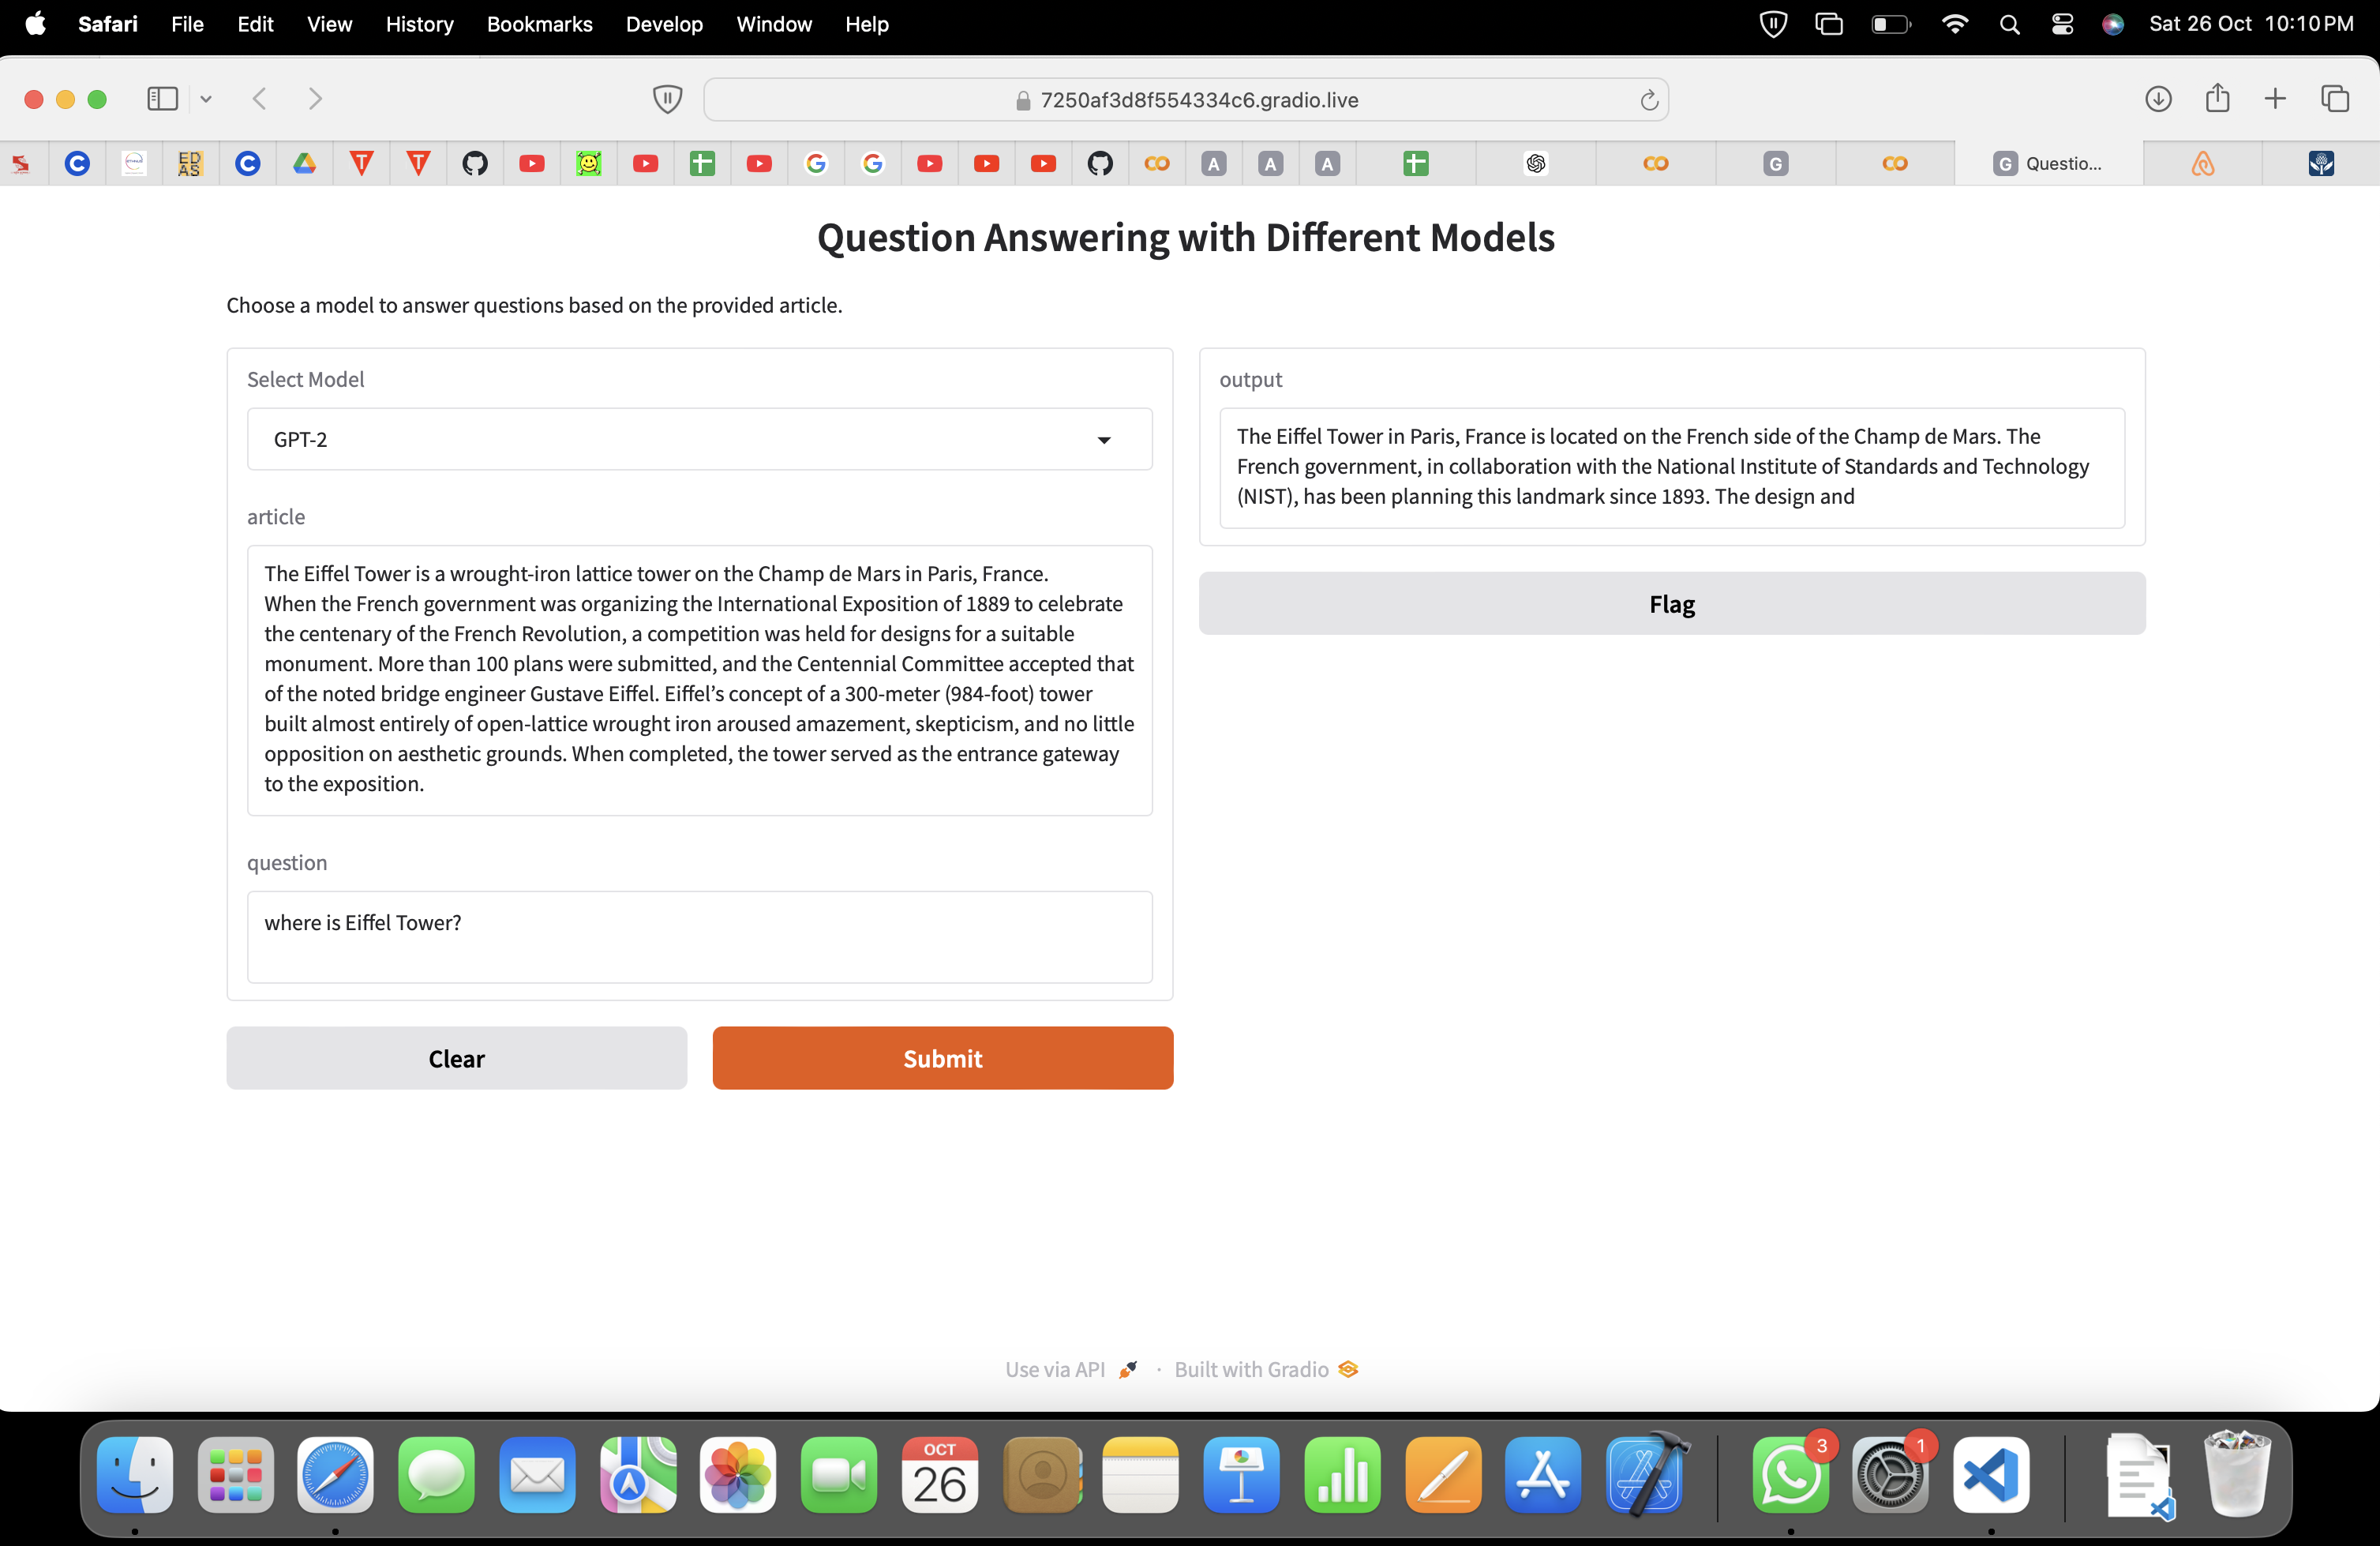

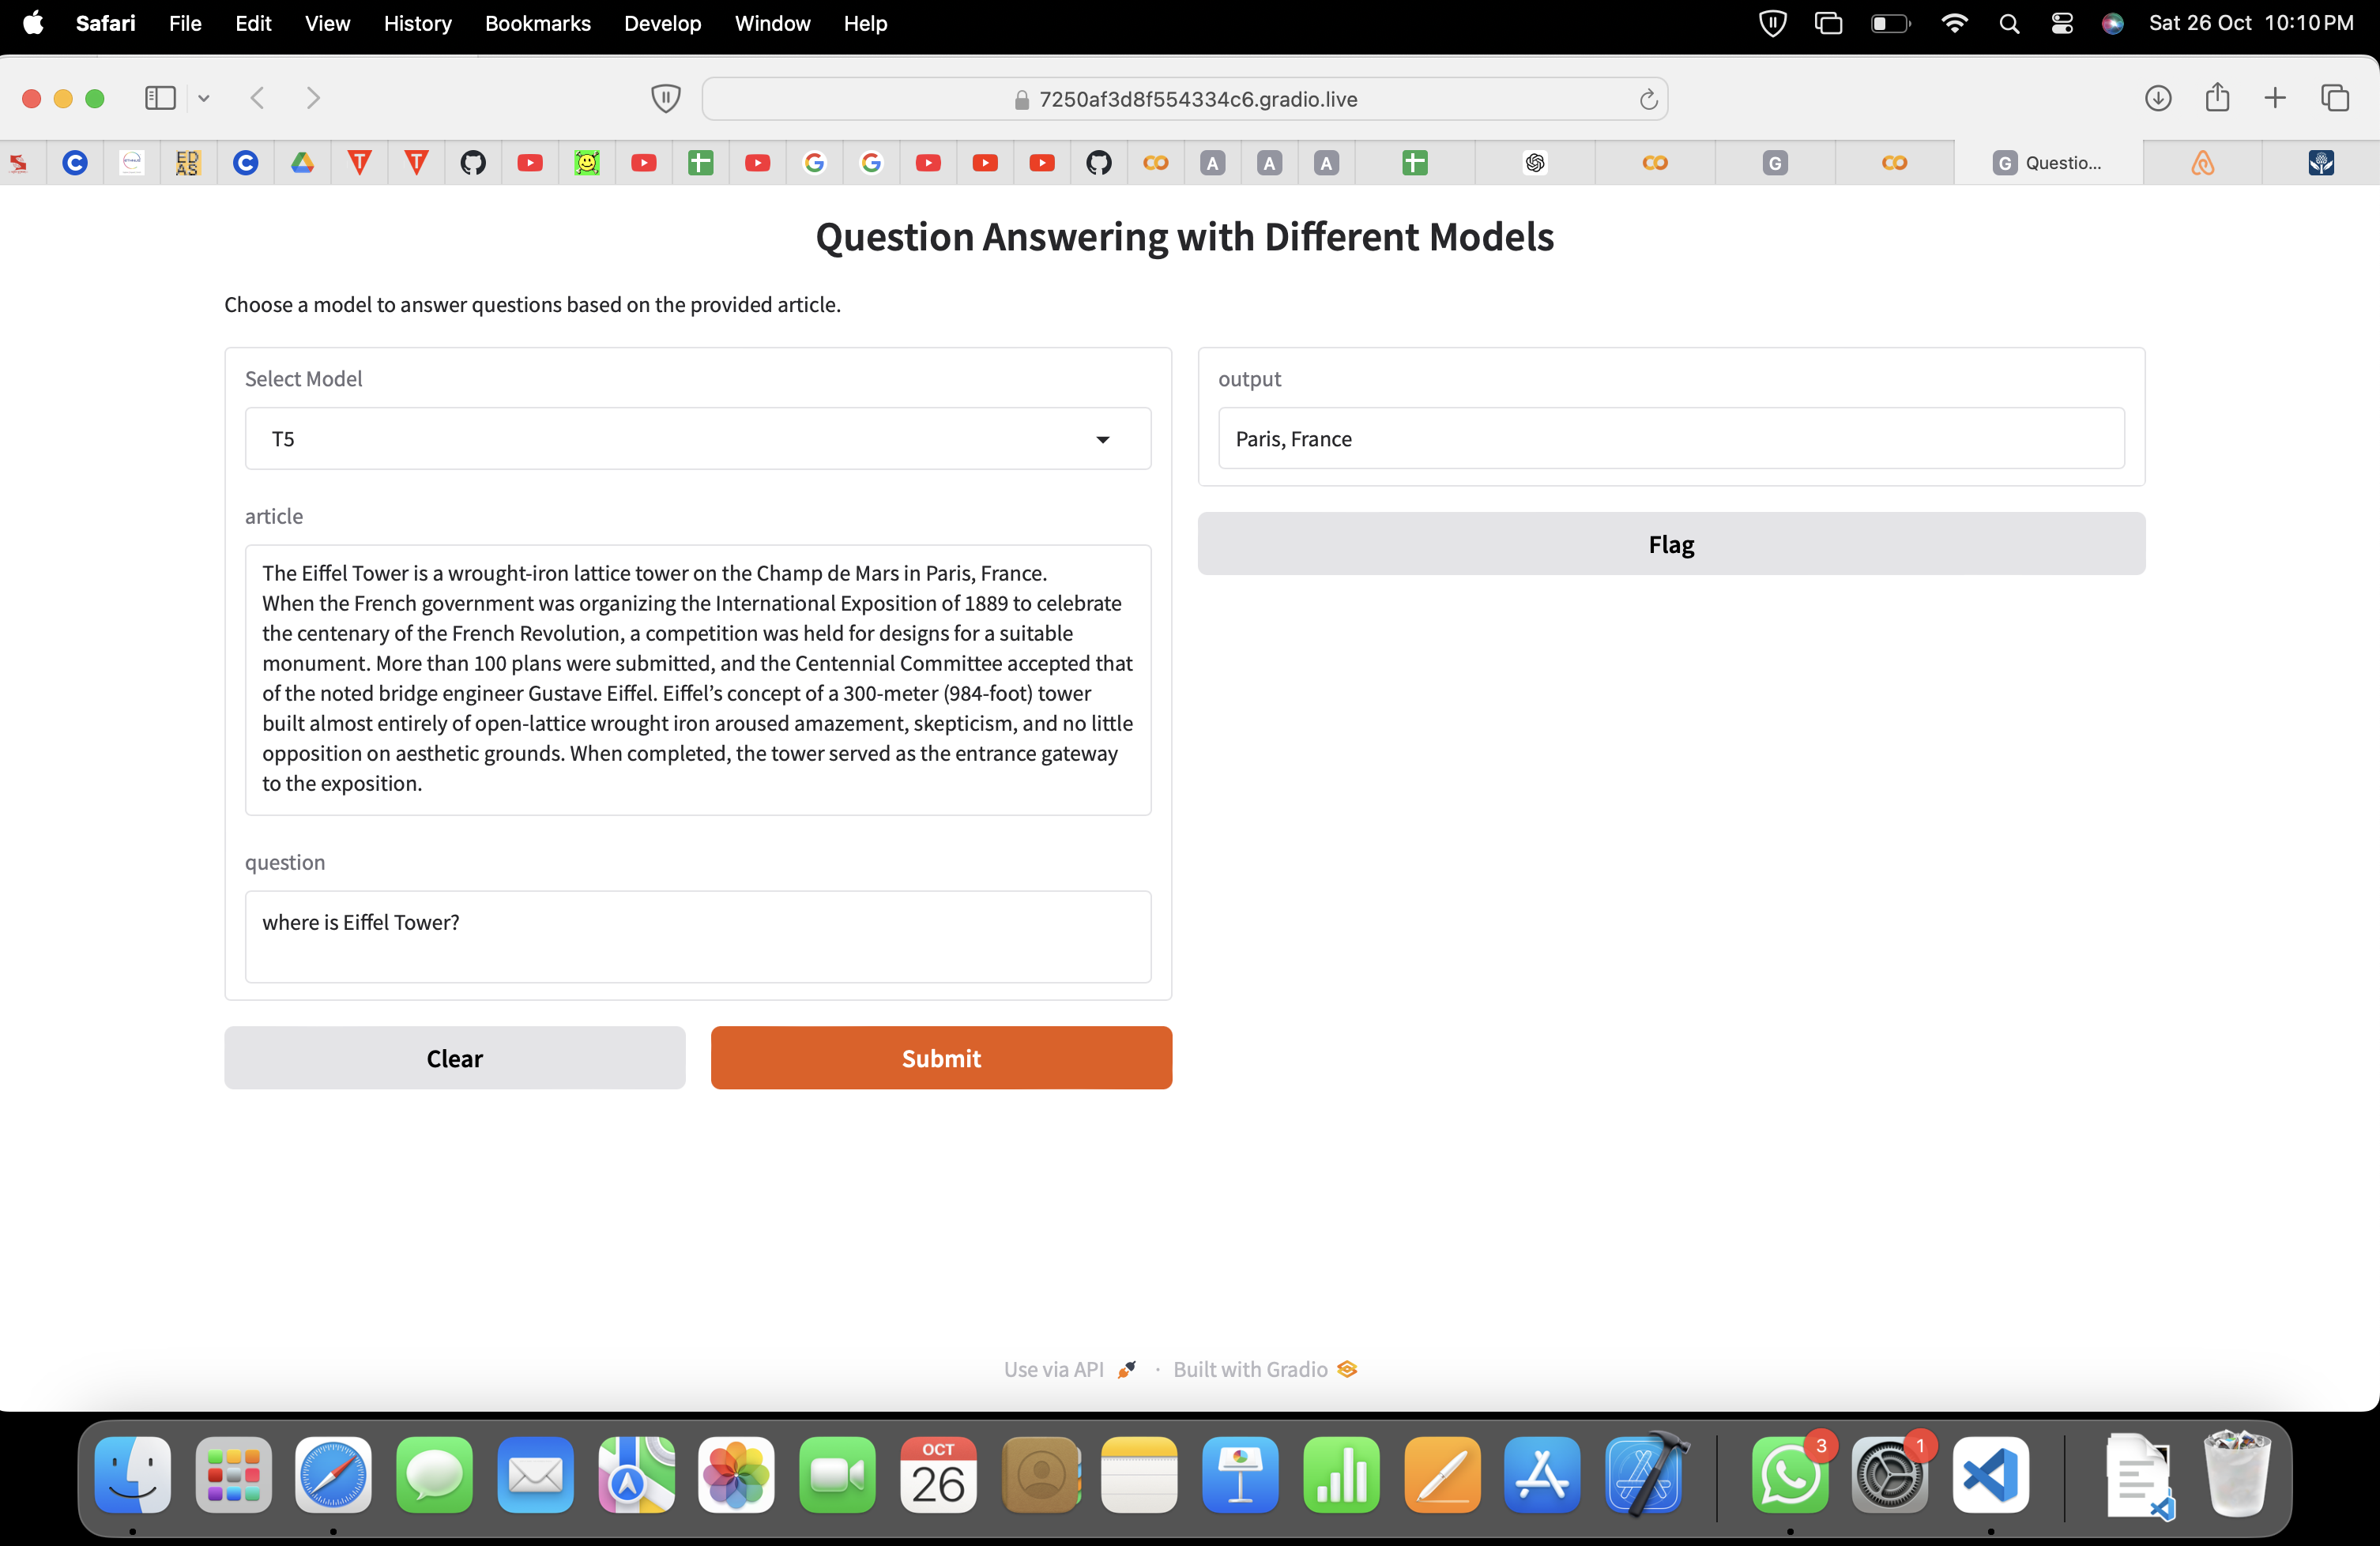

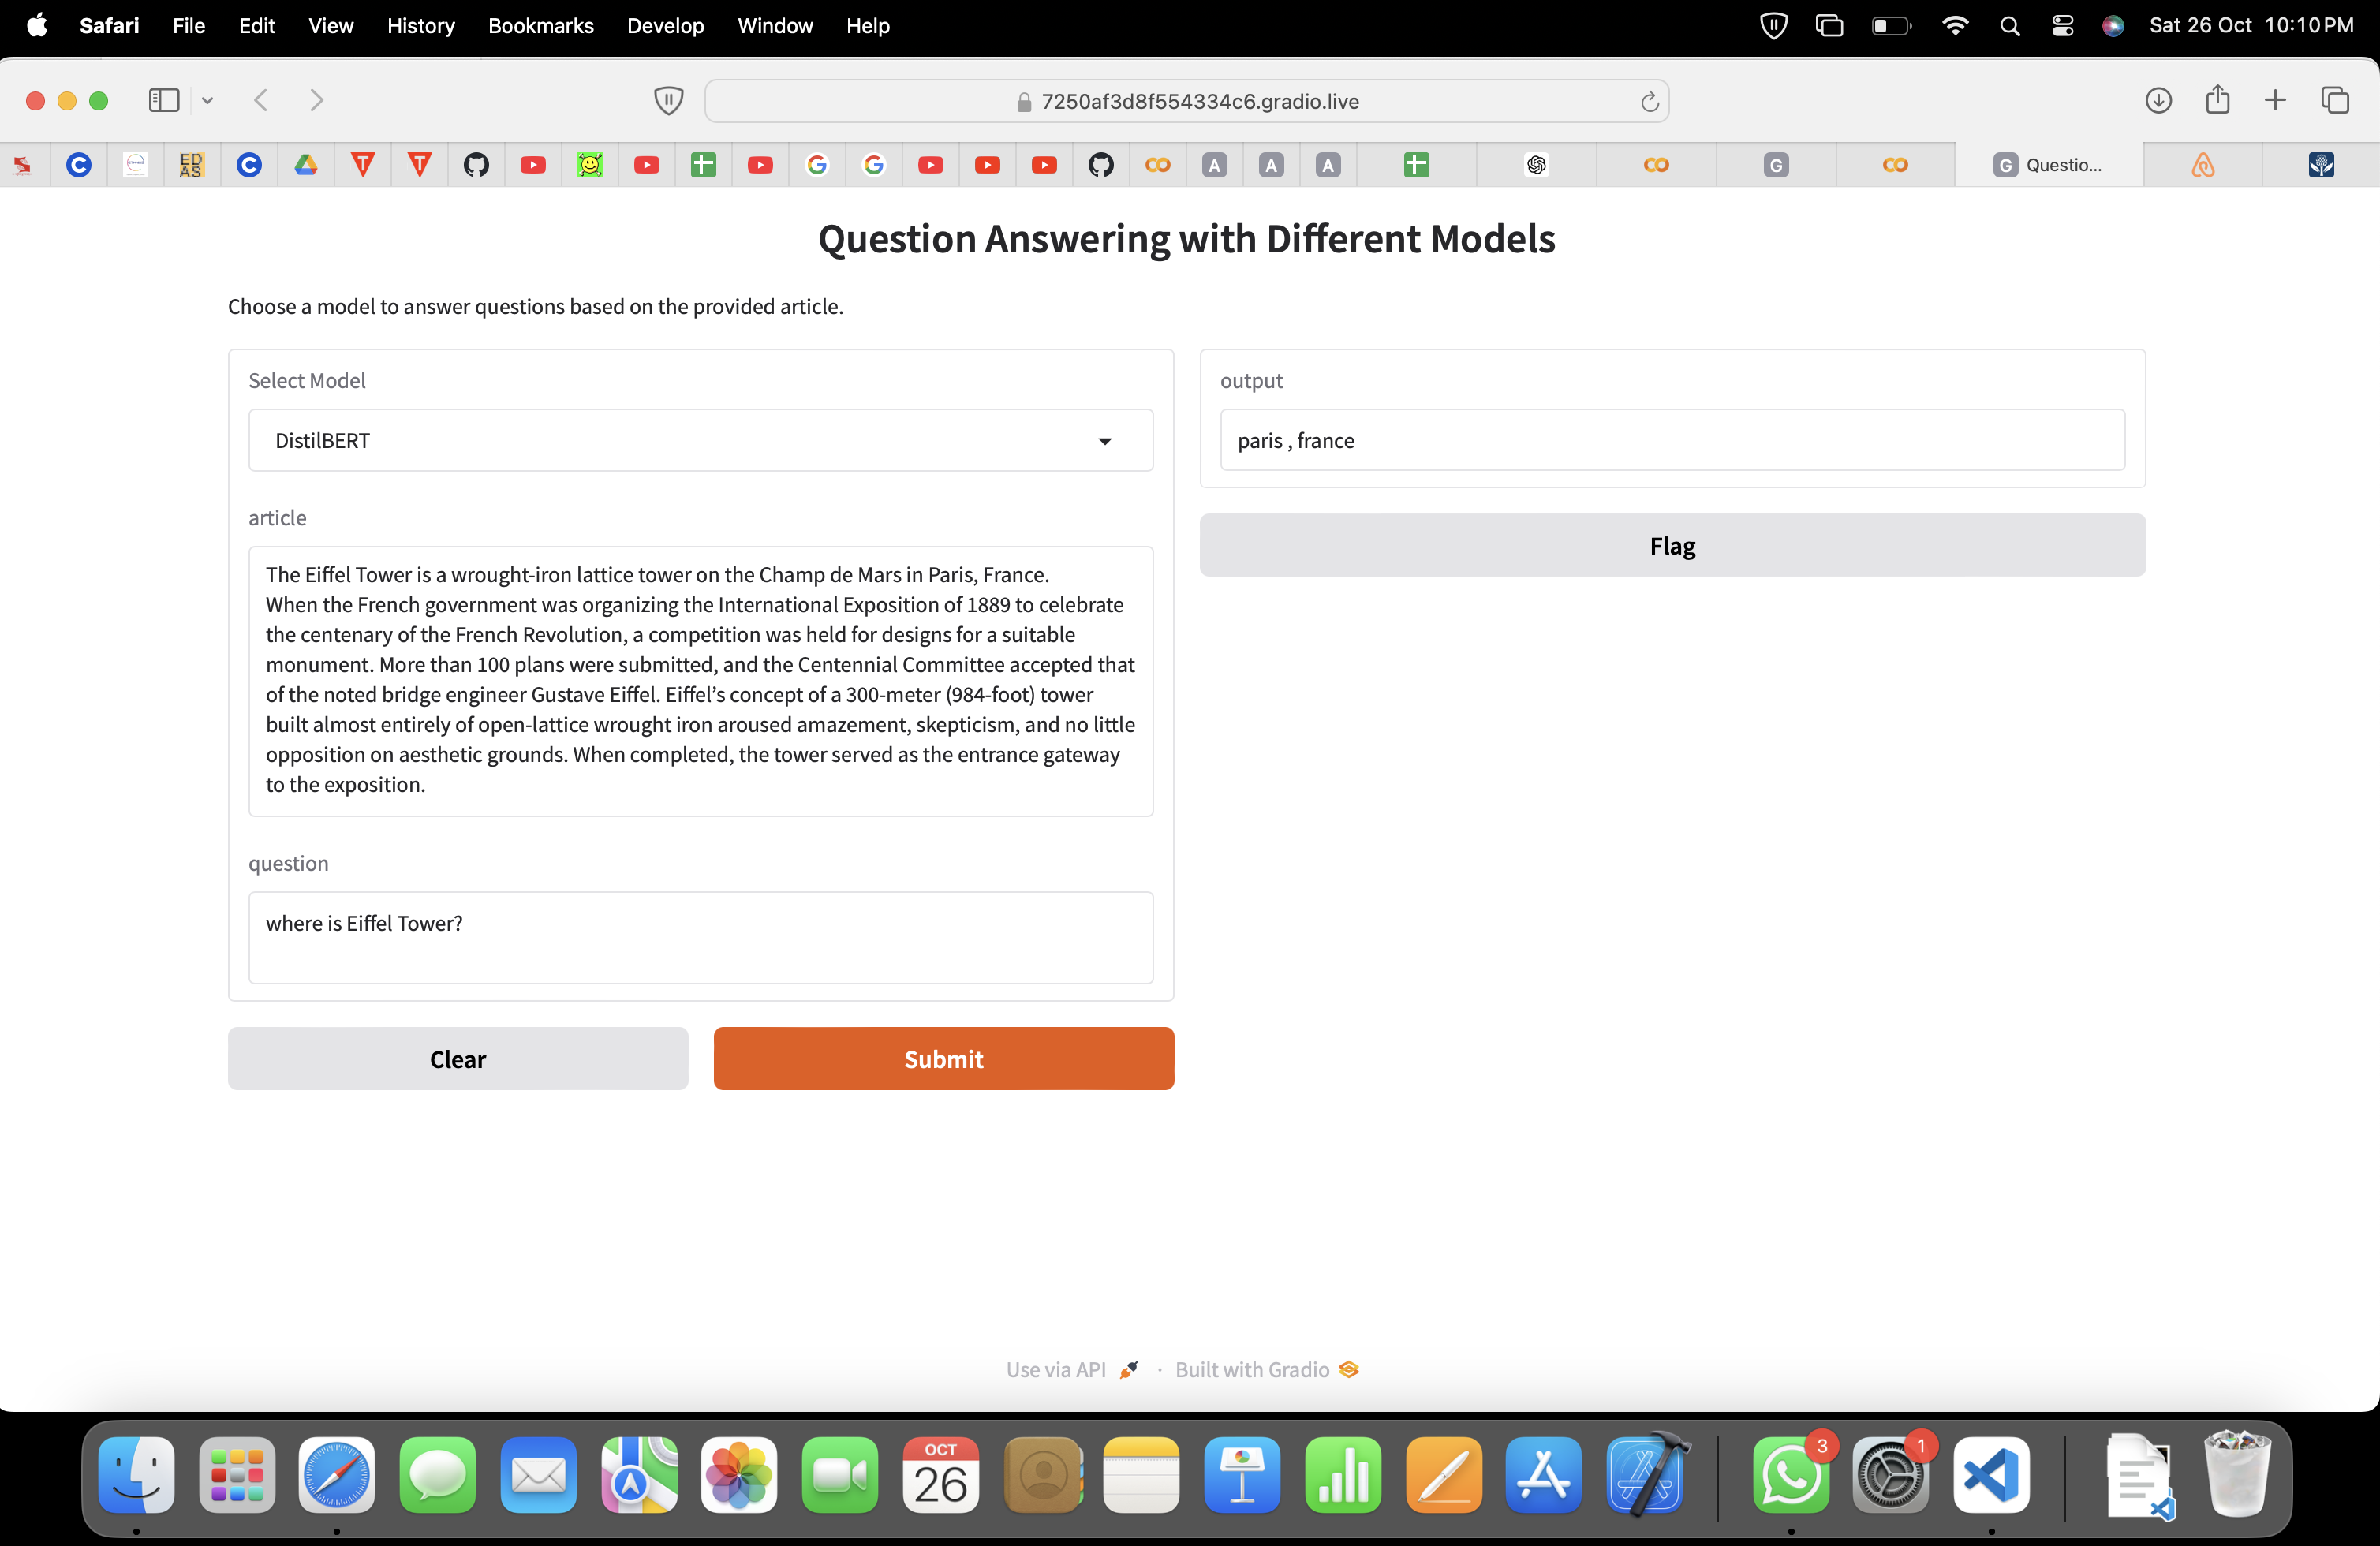

Github Link : https://github.com/DhwaniBhavankarKarthikeyan/NLPAssignments